## Demo for a simple feedforward network written from scratch

Alex Yuan, June 2018

### Step 1: import external and internal modules and functions

In [1]:
# import external modules and functions
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.datasets import load_boston

In [2]:
# import modules from this package
import ff_network as net
import fully_connected_layer as fcl
import activation_functions as afxn

### Step 2: import data and randomly divide into training, validation, and test sets

In [3]:
boston = load_boston()
X = boston.data # features
Y = boston.target # response
num_samples = len(Y)

msg = "There are %d samples in total" % (num_samples)
print(msg)

There are 506 samples in total


Let's divide the data into:
 * 400 training samples
 * 53 validation samples
 * 53 test samples

In [4]:
indices = [i for i in range(num_samples)]
np.random.shuffle(indices)
train_idx = indices[:400]
valid_idx = indices[400:453]
test_idx = indices[453:]

In [5]:
X_train = X[train_idx]
X_valid = X[valid_idx]
X_test = X[test_idx]

Y_train = Y[train_idx]
Y_valid = Y[valid_idx]
Y_test = Y[test_idx]

### Step 3: Build the network

Here, I'm using a Nesterov momentum optimizer with a learning rate of 0.001 and I'm limiting the absolute value of the gradient to be no more than 2. I'm using leaky relu in the activations.

The architecture is:

13-dim input --> layer1 --> 10-dim --> layer2 --> 5-dim --> layer3 --> 1-dim output

Check out the docstrings for ff_network.ff_network.\__init__ and fully_connected_layer.fully_connected_layer.\__init__ to see all of the available options!

In [6]:
# Initialize a network object
my_net = net.ff_newtork(learn_rate = .001, optimizer="Nesterov", grad_clip=2)
# Define the layers
layer1 = fcl.fully_connected_layer(13,10, activation_fxn=afxn.leaky_relu,
                                   afxn_prime=afxn.leaky_relu_prime)
layer2 = fcl.fully_connected_layer(10,5, activation_fxn=afxn.leaky_relu,
                                   afxn_prime=afxn.leaky_relu_prime)
layer3 = fcl.fully_connected_layer(5,1, activation_fxn=afxn.leaky_relu,
                                   afxn_prime=afxn.leaky_relu_prime)
# Add the layers to the network
my_net.add_layer(layer1)
my_net.add_layer(layer2)
my_net.add_layer(layer3)

### Step 4: Train the network

In [7]:
# User must choose batch size and number of epochs
batch_size = 20
num_epochs = 100

# Train the model!
train_loss = []
valid_loss = []
batches_per_epoch = int(len(X_train) / batch_size)
num_batches = batches_per_epoch * num_epochs
for i in range(num_batches):
    # prepare training batch
    rnd_indices = np.random.choice(a=len(X_train),
                                   size=batch_size, replace=False)
    batch_X = X_train[rnd_indices].T
    batch_Y = np.expand_dims(Y_train[rnd_indices],-1).T
    # prepare validation batch
    vld_indices = np.random.choice(a=len(X_valid),
                                   size=batch_size, replace=False)
    vld_X = X_valid[vld_indices].T
    vld_Y = np.expand_dims(Y_valid[vld_indices],-1).T
    # get validation loss
    yhat = my_net.predict(vld_X)
    valid_loss.append(np.mean(my_net.loss_fxn(vld_Y, yhat)))
    # train on training batch and get train loss
    train_loss.append(my_net.train(batch_X,batch_Y))

### Step 4.5: Look at training and validation loss

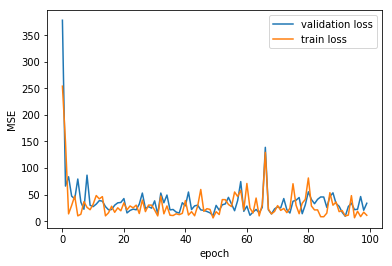

In [8]:
def x_grid(A):
    return [x for x in range(len(A))]

epoch_inds = [i for i in range(0, len(valid_loss), batches_per_epoch)]

plt.plot(x_grid(np.array(valid_loss)[epoch_inds]), np.array(valid_loss)[epoch_inds])
plt.plot(x_grid(np.array(train_loss)[epoch_inds]), np.array(train_loss)[epoch_inds])
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend(["validation loss", "train loss"])
plt.show()

It looks like our model from epoch 100 performs as well as any model we would get from early stopping, so to keep things simple let's just use this model and proceed to...

### Step 5: Predict on test data

In [9]:
Yhat_test = my_net.predict(X_test.T)

In [10]:
rsq = r2_score(Y_test,Yhat_test.flatten())
msg = "r-squared: %.2f" % rsq
print(msg)

r-squared: 0.58


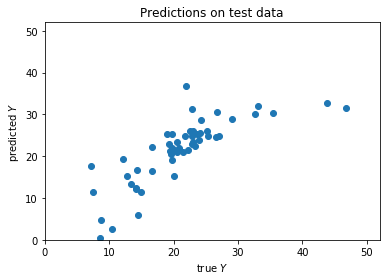

In [11]:
plt.scatter(Y_test,Yhat_test.flatten())
plt.title("Predictions on test data")
plt.xlabel("true $Y$")
plt.ylabel("predicted $Y$")
plt.xlim([0,52])
plt.ylim([0,52])
plt.show()

### Beware! Test performance is sensitive to how the data are partitioned into training, validation, and test sets. To get a better sense of performance, you should use cross-validation.